<a href="https://colab.research.google.com/github/BluBloos/QMIND2021-2022/blob/main/HandTracking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Right.

- So we seem to have everything split into seperate files now.
- What precisely is the next step?

- Make commit.

- Work to adapt the colab to also work.

- Integrate the work that Max has done with parsing_data.py.
- Integrate other changes in the google drive colab (not to be confused with the one that is in Github).
  - Namely, there are some changes to the MANO layer along with some work done for the loss functions.


# SETUP

In [1]:
# Download updated project from Github.
!git pull

# MOUNT GOOGLE DRIVE.
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

# TEST THE GOOGLE DRIVE MOUNT.
# with open('/content/drive/My Drive/foo.txt', 'w') as f:
#   f.write('Hello Google Drive!')
# !cat /content/drive/My\ Drive/foo.txt

###########3 TEST GPU AND RAM OF COLLAB INSTANCE ###########3
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')
###########3 TEST GPU AND RAM OF COLLAB INSTANCE ###########3

######### EXTERNAL LIBRARIES #########
import os
import pickle
import matplotlib.pyplot as plt
import imageio
import numpy as np
import time
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv2D, UpSampling2D, MaxPool2D
from tensorflow.keras import Model
print("TensorFlow version:", tf.__version__)
#NOTE: Good resource. -> https://www.tensorflow.org/tutorials/quickstart/advanced
import cv2 # opencv, for image resizing.
######### EXTERNAL LIBRARIES #########

############## HELPER FUNCTIONS ############## 
# NOTE(Noah): Stole this function from Stackoverflow :)
def rgb2gray(rgb):
    return np.expand_dims(np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140]), axis=2)
def resize(img, size):
    return cv2.resize(img, dsize=(size, size), interpolation=cv2.INTER_CUBIC)
############## HELPER FUNCTIONS ############## 

Already up to date.
/bin/bash: nvidia-smi: command not found
Your runtime has 17.2 gigabytes of available RAM
Not using a high-RAM runtime
TensorFlow version: 2.8.0


# MODEL LOADING

In [2]:
from mobilehand import MOBILE_HAND
from mobilehand_lfuncs import LOSS_3D

# The lower training loop assumes that the model is set as such.
model = MOBILE_HAND

# The lower training loop also assumes that we have the loss function set like so.
loss_fn = lambda pred, gt : LOSS_3D(pred,gt) 

2022-02-20 16:48:41.066533: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 288)               177408    
                                                                 
 dropout_1 (Dropout)         (None, 288)               0         
                                                                 
 dense_1 (Dense)             (None, 288)               83232     
                                                                 
 dropout_2 (Dropout)         (None, 288)               0         
                                                                 
 dense_2 (Dense)             (None, 39)                11271     
                                                                 
Total params: 271,911
Trainable params: 271,911
Non-trainable params: 0
_________________________________________________________________
tf.Tensor(
[[0.47440368 0.23429833 0.08797719 ..

# DATA LOADING

Loading in the training data samples...
Elapsed for LoadData training 3.663374185562134 s
Loading in the evaluation data samples...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Elapsed for LoadData evaluation 1.2401299476623535 s


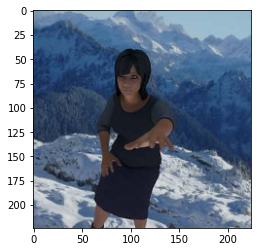

In [3]:
# Setup some params.
IMAGE_SIZE = 224
GRAYSCALE = False
TRAIN_AMOUNT = 192
TEST_AMOUNT = 96
IMAGE_CHANNELS = 1 if GRAYSCALE else 3

data_dir = '../RHD_small'

# Load in the testing and training images.
x_train = np.zeros( (TRAIN_AMOUNT, IMAGE_SIZE, IMAGE_SIZE, IMAGE_CHANNELS) )
y_train = np.zeros( (TRAIN_AMOUNT, 21, 3) )
x_test = np.zeros( (TEST_AMOUNT, IMAGE_SIZE, IMAGE_SIZE, IMAGE_CHANNELS) ) 
y_test = np.zeros( (TEST_AMOUNT, 21, 3) )

def LoadData(dataAmount, dataType, np1):
    path = os.path.join(data_dir, dataType)
    with open(os.path.join(path, 'anno_%s.pickle' % dataType), 'rb') as fi:
        anno_all = pickle.load(fi)

    count = 0 # count is the amount of data items that have been loaded thus far.
    for sample_id, anno in anno_all.items():
        image = imageio.imread(os.path.join(path, 'color', '%.5d.png' % sample_id))
        _image = image.astype('float32')
        if GRAYSCALE:
          _image = rgb2gray(_image / 255)
        else:
          _image = _image / 255
        _image = resize(_image, IMAGE_SIZE)
        np1[count, :, :, :] = _image

        count += 1
        if (count >= dataAmount):
            break

print("Loading in the training data samples...")
start_time = time.time()
LoadData(TRAIN_AMOUNT, 'training', x_train)
x_train = x_train.astype('float32')
#y_train = y_train.astype('float32')
end_time = time.time()
print('Elapsed for LoadData training', end_time - start_time, 's')

print("Loading in the evaluation data samples...")
start_time = time.time()
LoadData(TEST_AMOUNT, 'evaluation', x_test)
x_test = x_test.astype('float32')
#y_test = y_test.astype('float32')
end_time = time.time()
print('Elapsed for LoadData evaluation', end_time - start_time, 's')

# Test print one of the images from the dataset.
_test = x_train[0] 
plt.imshow(_test)
plt.show()
#_test = y_train[0]
#plt.imshow(np.squeeze(_test))
#plt.show()

# Batch the data for tensorflow.
train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).batch(32)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

# TODO(Noah): Is it feasible to now delete all the intermediate numpy arrays?
# TODO(Noah): Integrate code that max wrote to check if the dataset has been parsed.
# if the dataset has not been parsed yet, parse it, then load.

# TRAINING HELPER FUNCTIONS

In [4]:
class StupidSimpleLossMetric():
    def __init__(self):
        self.losses = [] # empty python array 
    def __call__(self, loss):
        self.losses.append(loss)
    def result(self):
        return sum(self.losses) / len(self.losses)
    def reset_states(self):
        self.losses = []

optimizer = tf.keras.optimizers.Adam() # defaults should work just fine
train_loss = StupidSimpleLossMetric()
test_loss = StupidSimpleLossMetric()

# loss_fn = keras.losses.BinaryCrossentropy(from_logits=False) # from_logits=False just means that the values are between zero and one (a probability).
# loss_fn = lambda x, y: tf.math.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(x, y))

# train_accuracy = tf.keras.metrics.MeanAbsolutePercentageError(name='train_accuracy')
# test_accuracy = tf.keras.metrics.MeanAbsolutePercentageError(name='test_accuracy')

# @tf.function Compiles a function into a callable TensorFlow graph.
# https://www.tensorflow.org/guide/intro_to_graphs
'''def custom_loss_func(pred, labels):
    #return tf.math.reduce_sum( tf.math.square(labels - tf.cast(pred,tf.float64)))
    # now trying pixel-wise cross-entropy loss
    return -tf.math.reduce_sum(tf.math.log(pred) * labels)
'''

# Loss function unit test
input = tf.zeros([1, 39])  # mock pred of all zeros
label = np.expand_dims(y_train[0], axis=0)
loss = loss_fn(input, label)
print('Loss for pred of all zeros', loss.numpy())
#loss2 = loss_fn(label, label)
#print('Loss for perfect prediction', loss2.numpy())
input2 = tf.ones([1, 39])
loss3 = loss_fn(input2, label)
print('Loss for pred of all ones', loss3.numpy())

Loss for pred of all zeros 0.0
Loss for pred of all ones 0.6190476417541504


# TRAINING LOOP

In [5]:
@tf.function
def train_step(input, gt):
    with tf.GradientTape() as tape:
        predictions = model(input)
        #loss = loss_func(predictions, segmentation_masks)
        #loss = np.dot(tf.reshape(segmentation_masks, [102400], tf.reshape(predictions, [102400])
        loss = loss_fn(predictions, gt)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss
    #train_accuracy(labels, predictions)
  
@tf.function
def test_step(images, labels):
  # training=False is only needed if there are layers with different
  # behavior during training versus inference (e.g. Dropout).
  predictions = model(images, training=False)
  return loss_fn(predictions, labels)
  #test_accuracy(labels, predictions)

In [6]:
# TODO: Reimplement loading in the saved model weights
# model.load_weights(checkpoint_path)

EPOCHS = 10 # sure...

for epoch in range(EPOCHS):
  # Reset the metrics at the start of the next epoch
  print("Epoch", epoch)
  start = time.time()
  train_loss.reset_states()
  #train_accuracy.reset_states()
  test_loss.reset_states()
  #test_accuracy.reset_states()

  for images, labels in train_ds:
    loss = train_step(images, labels)
    train_loss(loss.numpy())

  for test_images, test_labels in test_ds:
    loss = test_step(test_images, test_labels)
    test_loss(loss.numpy())

  end = time.time()

  print(
    f'Epoch {epoch + 1}, '
    f'Time {end-start} s'
    f'Loss: {train_loss.result()}, '
    f'Test Loss: {test_loss.result()}, '
  )

  # for each epoch, we want to show the 
  #pred = model( _image )
  #plt.imshow(np.squeeze(pred))
  #plt.show()

# Save the model parameters
# TODO: Make it such that model parameters are saved after x many epochs as opposed to however
#   many epochs the model will be trained in total
#save_dir = '/content/drive/My Drive'
#checkpoint_path = save_dir + "/cp-{epoch:04d}.ckpt"
#model.save('current_model.h5py',save_path)
#model.save_weights(checkpoint_path.format(epoch=40))

Epoch 0
Epoch 1, Time 13.684455156326294 sLoss: 0.0040936635341495275, Test Loss: 1.7556988192761008e-05, 
Epoch 1
Epoch 2, Time 7.320096015930176 sLoss: 3.92461326189734e-06, Test Loss: 0.0, 
Epoch 2
Epoch 3, Time 7.230170011520386 sLoss: 4.880648892443181e-08, Test Loss: 0.0, 
Epoch 3
Epoch 4, Time 7.237004041671753 sLoss: 2.179782186232752e-08, Test Loss: 0.0, 
Epoch 4
Epoch 5, Time 7.588890790939331 sLoss: 0.0, Test Loss: 0.0, 
Epoch 5
Epoch 6, Time 7.612385034561157 sLoss: 0.0, Test Loss: 0.0, 
Epoch 6
Epoch 7, Time 7.424605846405029 sLoss: 0.0, Test Loss: 0.0, 
Epoch 7
Epoch 8, Time 8.374225854873657 sLoss: 0.0, Test Loss: 0.0, 
Epoch 8
Epoch 9, Time 7.229404926300049 sLoss: 0.0, Test Loss: 0.0, 
Epoch 9
Epoch 10, Time 7.2433762550354 sLoss: 0.0, Test Loss: 0.0, 


PermissionDeniedError: /content; Read-only file system